In [169]:
# Data Processing
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Imbalanced Data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC

# Modelling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [170]:
cleaned_churners = pd.read_csv('churners_clean_df.csv')

In [171]:
# Replace Unknown values by nan in categorical data
cleaned_churners.replace('Unknown', np.nan, inplace=True)

In [172]:
# Get the unique values of categorical columns
cat_cols = cleaned_churners.select_dtypes(include = 'object').columns.tolist()
for col in cat_cols:
    unique_values = cleaned_churners[col].unique()
    print(f"Unique values in '{col}' are: {unique_values}")

Unique values in 'Attrition_Flag' are: ['Existing Customer' 'Attrited Customer']
Unique values in 'Gender' are: ['M' 'F']
Unique values in 'Education_Level' are: ['Graduate' 'Uneducated' 'Doctorate' nan 'High School' 'College'
 'Post-Graduate']
Unique values in 'Marital_Status' are: ['Married' nan 'Divorced' 'Single']
Unique values in 'Income_Category' are: ['$40K - $60K' '$120K +' 'Less than $40K' '$60K - $80K' '$80K - $120K']
Unique values in 'Card_Category' are: ['Blue' 'Gold' 'Silver' 'Platinum']


### Imbalanced data

In [173]:
X = cleaned_churners.drop('Attrition_Flag', axis=1)
y = cleaned_churners['Attrition_Flag']

In [174]:
print (type(X))

<class 'pandas.core.frame.DataFrame'>


Class distribution

In [175]:
y.value_counts()

Attrition_Flag
Existing Customer    6970
Attrited Customer    1365
Name: count, dtype: int64

<Axes: ylabel='count'>

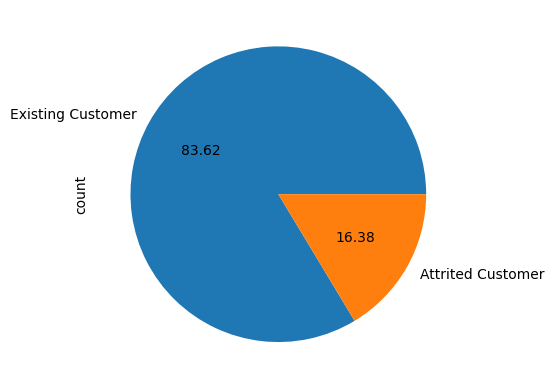

In [176]:
y.value_counts().plot.pie(autopct='%.2f')

Random Undersampling <br>
'not minority' = resample all classes but the minority class

Attrition_Flag
Attrited Customer    1365
Existing Customer    1365
Name: count, dtype: int64

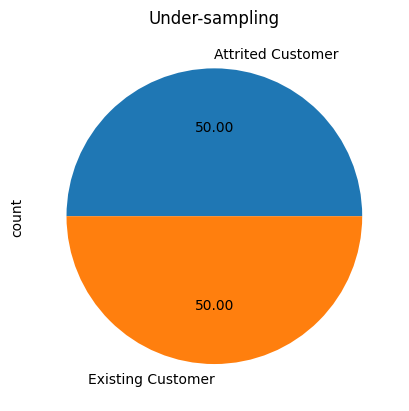

In [177]:
rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_rus, y_rus = rus.fit_resample(X, y)

ax = y_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

# Class distribution after resampling
y_rus.value_counts()

Random Oversampling <br>
"not majority" = resample all classes but the majority class

Attrition_Flag
Existing Customer    6970
Attrited Customer    6970
Name: count, dtype: int64

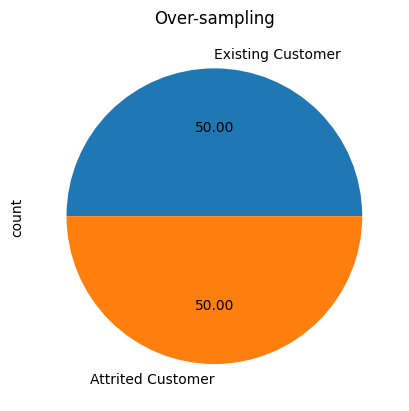

In [178]:
# ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_ros, y_ros = ros.fit_resample(X, y)

ax = y_ros.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

y_ros.value_counts()

SMOTENC: SMOTE with categorical features

In [179]:
display(X.head())
cat = X.select_dtypes(include = 'object').columns
# get index of cat columns
index = X.columns.get_indexer(cat)
print(index)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,1.376,1088,24,0.846,0.311
1,42,M,5,Uneducated,NaN,$120K +,Blue,31,5,3,2,6748.0,1467,0.831,1201,42,0.680,0.217
2,57,F,2,Graduate,Married,Less than $40K,Blue,48,5,2,2,2436.0,680,1.190,1570,29,0.611,0.279
3,47,M,1,Doctorate,Divorced,$60K - $80K,Blue,42,5,2,0,20979.0,1800,0.906,1178,27,0.929,0.086
4,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1.047,692,16,0.600,0.000


[1 3 4 5 6]


In [180]:
smo = SMOTENC(sampling_strategy="minority", categorical_features=[1,3,4,5,6])
X_smo, y_smo = smo.fit_resample(X, y)

Attrition_Flag
Existing Customer    6970
Attrited Customer    6970
Name: count, dtype: int64

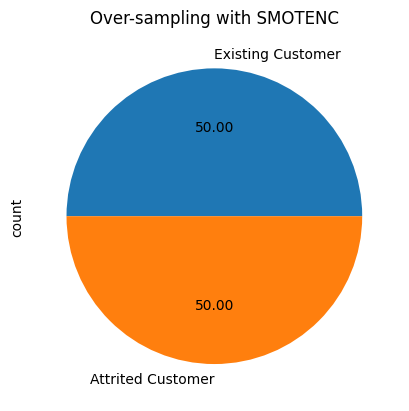

In [201]:
ax = y_smo.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling with SMOTENC")

y_smo.value_counts()

Training

In [181]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, random_state=42, test_size=0.3)

In [182]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define numerical and categorical features
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_features = X_train.select_dtypes(include='object').columns

# Define preprocessing steps for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing steps for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the preprocessor on the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get the column names after one-hot encoding
encoded_categorical_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine numerical and categorical column names
all_feature_names = list(numerical_features) + list(encoded_categorical_columns)
print(all_feature_names)

# Create DataFrames with preprocessed features
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Check the preprocessed DataFrames
print("Preprocessed Training Data:")
display(X_train_preprocessed_df.head())

print("\nPreprocessed Testing Data:")
print(X_test_preprocessed_df.head())


['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Gender_F', 'Gender_M', 'Education_Level_College', 'Education_Level_Doctorate', 'Education_Level_Graduate', 'Education_Level_High School', 'Education_Level_Post-Graduate', 'Education_Level_Uneducated', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Income_Category_$120K +', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver']
Preprocessed Training Data:


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Marital_Status_Single,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.386115,-0.192382,0.862773,-0.314496,0.818564,-0.472451,0.500848,-0.890095,1.802223,0.670095,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.999889,-1.849274,0.028513,-0.314496,0.818564,0.546598,-0.584626,-1.070039,0.642336,0.452317,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.445487,0.636065,0.028513,1.650198,-1.552683,0.546598,-0.584626,1.605501,-0.156944,-0.801235,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.940517,-0.192382,0.445643,-1.624292,-0.367060,0.546598,-0.482647,1.760702,0.548113,-0.433213,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.029686,-0.192382,0.028513,0.995300,-0.367060,-0.472451,-0.209070,-1.070039,-0.686196,-0.650991,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0



Preprocessed Testing Data:
   Customer_Age  Dependent_count  Months_on_book  Total_Relationship_Count  \
0     -0.861289         0.636065       -0.944792                  0.340402   
1      0.940517        -1.849274       -0.249574                 -0.969394   
2      0.801917         0.636065        0.306600                  0.995300   
3      0.940517        -1.020828        1.140860                 -1.624292   
4      0.801917         0.636065        0.028513                 -0.969394   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0               -1.552683               1.565648      0.899018   
1                0.818564               0.546598     -0.670142   
2               -0.367060              -0.472451      2.877153   
3                2.004187               1.565648      0.849274   
4               -1.552683              -0.472451     -0.669033   

   Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  ...  \
0            -0.688783             -

In [183]:
# Fit and transform the preprocesing steps on the training data
preprocessed = preprocessor.fit(X_train)

X_train_processed = preprocessed.transform(X_train)
X_test_processed = preprocessed.transform(X_test)

In [184]:
print(type(X_train_processed))
print(type(X_train))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


Classifiers: KNN Classifier

In [185]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_processed, y_train)

KNeighborsClassifier()

In [186]:
# Make predictions
y_pred = knn.predict(X_test_processed)

# Evaluate the model
print(round(knn.score(X_test_processed, y_test),2))

# Confusion matrix
confusion_matrix(y_test, y_pred)
crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)
display(crosstab)

# Generate classification report
report = classification_report(y_test, y_pred, zero_division=1)
print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")


0.92


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2048,46,2094
Existing Customer,281,1807,2088
All,2329,1853,4182


Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.88      0.98      0.93      2094
Existing Customer       0.98      0.87      0.92      2088

         accuracy                           0.92      4182
        macro avg       0.93      0.92      0.92      4182
     weighted avg       0.93      0.92      0.92      4182



Classifiers: Random Forest

In [187]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

In [203]:
# Make predictions
y_pred = rf_model.predict(X_test_processed)

# Evaluate the model
print(round(rf_model.score(X_test_processed, y_test),3))

# Confusion matrix
confusion_matrix(y_test, y_pred)
crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)
display(crosstab)

0.975


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2063,31,2094
Existing Customer,75,2013,2088
All,2138,2044,4182


In [189]:
# Generate classification report
report = classification_report(y_test, y_pred, zero_division=1)
print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")

Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.96      0.99      0.97      2094
Existing Customer       0.98      0.96      0.97      2088

         accuracy                           0.97      4182
        macro avg       0.97      0.97      0.97      4182
     weighted avg       0.97      0.97      0.97      4182



Classifiers: Decision Tree

In [190]:
# Train Decision Tree on Classification Task
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_clf.fit(X_train_processed, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [191]:
# Print Text Representation
text_representation = tree.export_text(dt_clf)
print(text_representation)

|--- feature_10 <= -0.03
|   |--- feature_7 <= -0.33
|   |   |--- feature_3 <= -0.64
|   |   |   |--- feature_11 <= 2.42
|   |   |   |   |--- feature_12 <= 0.59
|   |   |   |   |   |--- feature_1 <= 1.88
|   |   |   |   |   |   |--- feature_24 <= 0.50
|   |   |   |   |   |   |   |--- class: Attrited Customer
|   |   |   |   |   |   |--- feature_24 >  0.50
|   |   |   |   |   |   |   |--- feature_8 <= 0.31
|   |   |   |   |   |   |   |   |--- class: Attrited Customer
|   |   |   |   |   |   |   |--- feature_8 >  0.31
|   |   |   |   |   |   |   |   |--- feature_8 <= 0.38
|   |   |   |   |   |   |   |   |   |--- class: Existing Customer
|   |   |   |   |   |   |   |   |--- feature_8 >  0.38
|   |   |   |   |   |   |   |   |   |--- class: Attrited Customer
|   |   |   |   |   |--- feature_1 >  1.88
|   |   |   |   |   |   |--- feature_10 <= -0.31
|   |   |   |   |   |   |   |--- class: Attrited Customer
|   |   |   |   |   |   |--- feature_10 >  -0.31
|   |   |   |   |   |   |   |--- clas

In [192]:
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)

Plot Tree with plot_tree

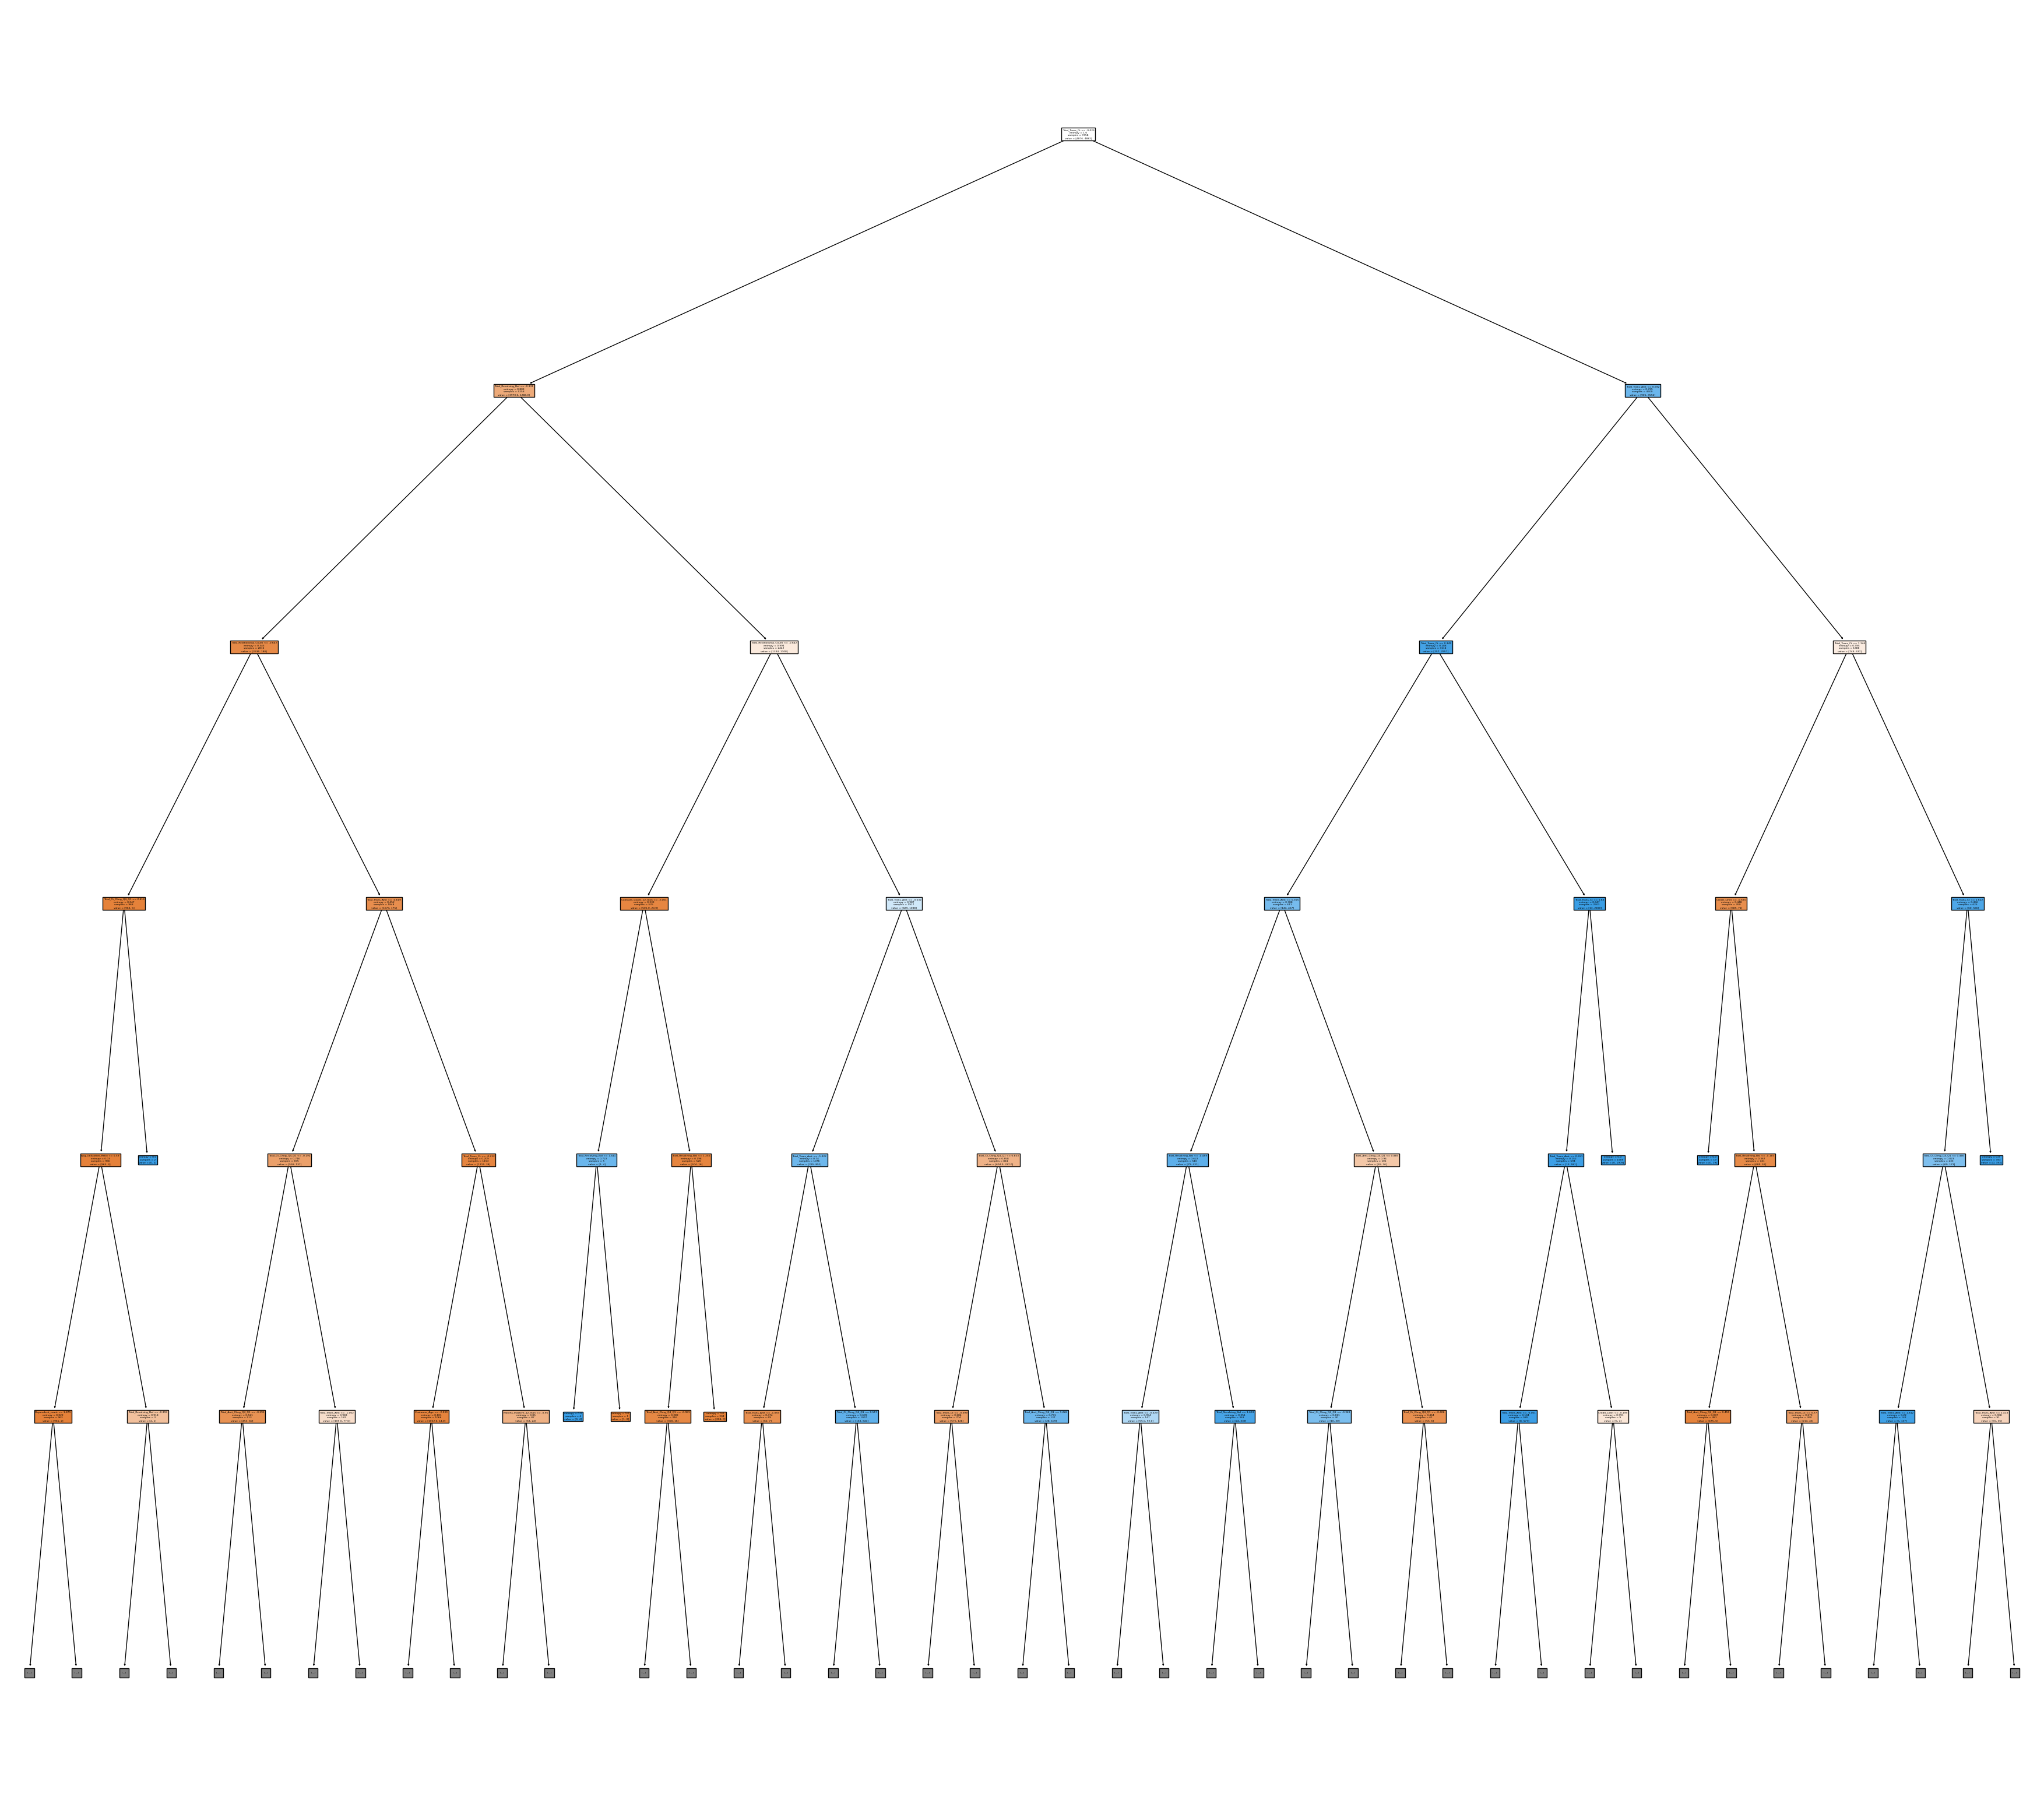

In [199]:
fig = plt.figure(figsize=(45,40))
_ = tree.plot_tree(dt_clf, feature_names=X_train_preprocessed_df.columns, max_depth=5, filled=True)

In [194]:
fig.savefig("decistion_tree.png")

Visualize Decision Tree with graphviz

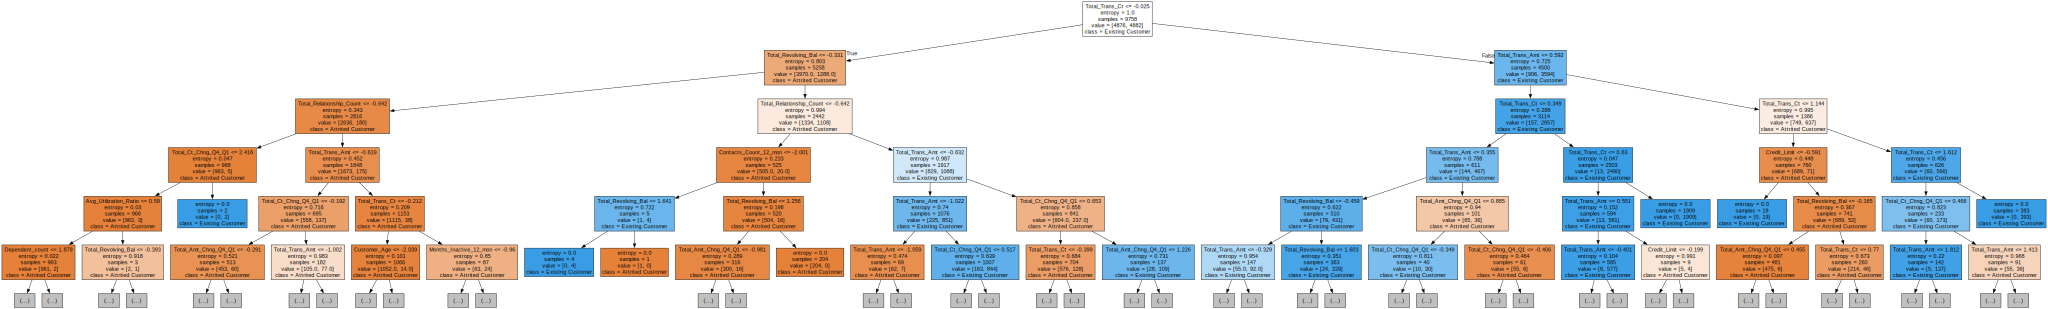

In [195]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(dt_clf, feature_names=X_train_preprocessed_df.columns, 
                                class_names=["Attrited Customer", "Existing Customer"], 
                                max_depth=5,out_file=None, filled=True)

# Drow graph
graph = graphviz.Source(dot_data, format="png")
graph

In [196]:
graph.render("decision_tree_grphviz")

'decision_tree_grphviz.png'

In [197]:
# Make predictions
y_pred = dt_clf.predict(X_test_processed)

# Evaluate the model
print(round(dt_clf.score(X_test_processed, y_test),2))

# Confusion matrix
confusion_matrix(y_test, y_pred)
crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)
display(crosstab)

# Generate classification report
report = classification_report(y_test, y_pred, zero_division=1)
print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")


0.95


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2023,71,2094
Existing Customer,118,1970,2088
All,2141,2041,4182


Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.94      0.97      0.96      2094
Existing Customer       0.97      0.94      0.95      2088

         accuracy                           0.95      4182
        macro avg       0.96      0.95      0.95      4182
     weighted avg       0.96      0.95      0.95      4182



ROC curve

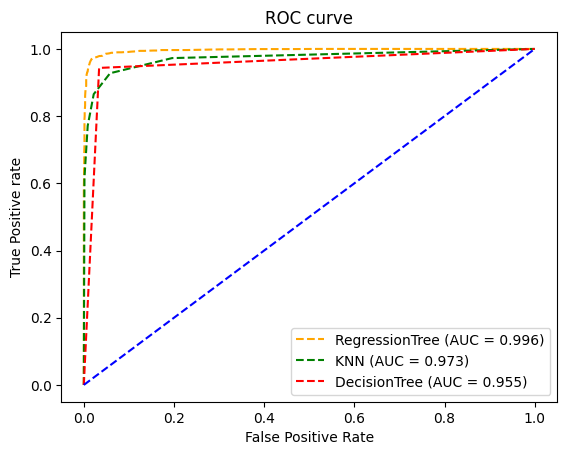

In [198]:
# Predict probabilities
y_prob1 = rf_model.predict_proba(X_test_processed)
y_prob2 = knn.predict_proba(X_test_processed)
y_prob3 = dt_clf.predict_proba(X_test_processed)

# ROC curve for model
fpr1, tpr1, thresh1 = roc_curve(y_test, y_prob1[:,1], 
                        pos_label='Existing Customer')
fpr2, tpr2, thresh2 = roc_curve(y_test, y_prob2[:,1],
                        pos_label='Existing Customer')
fpr3, tpr3, thresh3 = roc_curve(y_test, y_prob3[:,1],
                        pos_label='Existing Customer')

# ROC curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, 
                    pos_label='Existing Customer')

# auc scores
auc_score1 = roc_auc_score(y_test, y_prob1[:,1])
auc_score2 = roc_auc_score(y_test, y_prob2[:,1])
auc_score3 = roc_auc_score(y_test, y_prob3[:,1])

# print(f"RegressionTree: {auc_score1}, KNN: {auc_score2}, DecisionTree: {auc_score3}")

# plot ROC curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='RegressionTree (AUC = %0.3f)' % auc_score1)
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN (AUC = %0.3f)' % auc_score2)
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='DecisionTree (AUC = %0.3f)' % auc_score3)

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# labels
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

